In [265]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import gc
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import SGD, Adam
from keras.regularizers import l2
from keras.callbacks import LearningRateScheduler

In [2]:
train_2016 = pd.read_csv('train_2016_v2.csv',parse_dates=['transactiondate'])
train_2017 = pd.read_csv('train_2017.csv',parse_dates=['transactiondate'])
train_2016 = train_2016.drop('transactiondate', axis=1)
train_2017 = train_2017.drop('transactiondate', axis=1)

In [3]:
train_2016 = train_2016.set_index('parcelid')
train_2017 = train_2017.set_index('parcelid')
train_2016 = train_2016.groupby(train_2016.index).first()
train_2017 = train_2017.groupby(train_2017.index).first()
train_2016.update(train_2017)
train_2016 = train_2016.reset_index()

In [4]:
test = pd.read_csv('sample_submission.csv')
test_data = pd.DataFrame({'parcelid':test['ParcelId']})

In [5]:
properties_2016 = pd.read_csv('properties_2016.csv')
properties_2017 = pd.read_csv('properties_2017.csv')

/Users/ahmedaleshinloye/anaconda/envs/gl-env/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/ahmedaleshinloye/anaconda/envs/gl-env/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
(properties_2016['parcelid'].isin(properties_2017['parcelid'])).value_counts()

True    2985217
Name: parcelid, dtype: int64

In [7]:
properties_2017.head(5)

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,10754147,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,9.0,2016.0,9.0,NaN,NaN,NaN,NaN
1,10759547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,27516.0,2015.0,27516.0,NaN,NaN,NaN,NaN
2,10843547,NaN,NaN,NaN,0.0,0.0,5.0,NaN,NaN,NaN,...,1.0,NaN,660680.0,1434941.0,2016.0,774261.0,20800.37,NaN,NaN,NaN
3,10859147,NaN,NaN,NaN,0.0,0.0,3.0,6.0,NaN,NaN,...,1.0,NaN,580059.0,1174475.0,2016.0,594416.0,14557.57,NaN,NaN,NaN
4,10879947,NaN,NaN,NaN,0.0,0.0,4.0,NaN,NaN,NaN,...,1.0,NaN,196751.0,440101.0,2016.0,243350.0,5725.17,NaN,NaN,NaN


In [8]:
properties_2017.tail(5)

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
2985212,12170430,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2985213,11422430,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2985214,17203030,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2985215,14242830,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2985216,12766630,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
train_data = pd.merge(train_2016,properties_2017, how='left', on='parcelid')
test_data = pd.merge(test_data, properties_2017, how='left', on='parcelid')

In [157]:
data = train_data.append(test_data)

In [ ]:
del properties_2016, properties_2017, train_2016, train_2017
gc.collect()

In [160]:
data['assessmentyear'].unique()

array([ 2016.,    nan,  2015.,  2014.,  2003.,  2012.,  2001.,  2011.,
        2013.,  2010.,  2004.,  2005.,  2002.,  2000.,  2009.])

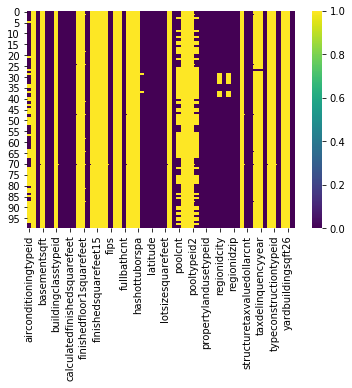

In [161]:
sns.heatmap(data.head(100).isnull() == True, cmap='viridis')

In [162]:
sum_null = []
for c in data.columns:
    sum_value =(data[c].isnull()).sum()
    sum_null.append(sum_value)
df = pd.DataFrame({'columns':data.columns, 'sum of null': sum_null})

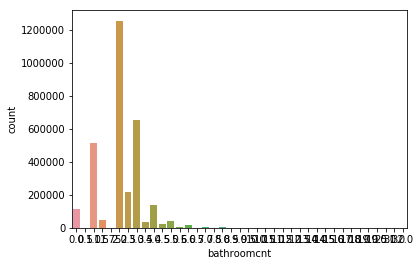

In [163]:
sns.countplot(x='bathroomcnt', data= data)

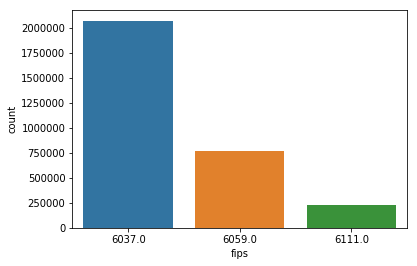

In [164]:
sns.countplot(x='fips', data = data)

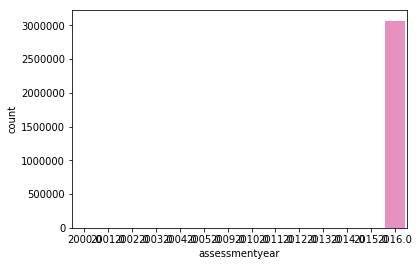

In [165]:
sns.countplot(x = 'assessmentyear',data = data)

In [166]:
data.assessmentyear.unique()

array([ 2016.,    nan,  2015.,  2014.,  2003.,  2012.,  2001.,  2011.,
        2013.,  2010.,  2004.,  2005.,  2002.,  2000.,  2009.])

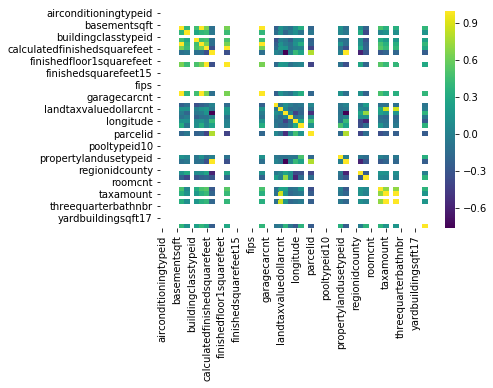

In [167]:
sns.heatmap(data.head(100).corr(), cmap= 'viridis')

In [168]:
data.describe()

,airconditioningtypeid,architecturalstyletypeid,assessmentyear,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,...,structuretaxvaluedollarcnt,taxamount,taxdelinquencyyear,taxvaluedollarcnt,threequarterbathnbr,typeconstructiontypeid,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt
count,844246.000000,6321.000000,3.072417e+06,1670.000000,3.072393e+06,3.072405e+06,12748.000000,1.998746e+06,2.957348e+06,3.029886e+06,...,3.028601e+06,3.052587e+06,58291.000000,3.041083e+06,328463.000000,7044.000000,2.039402e+06,84285.000000,2741.000000,3.027030e+06
mean,1.941639,7.203765,2.015998e+03,648.929341,2.218484e+00,3.091986e+00,3.735096,6.288116e+00,2.304180e+00,1.829867e+03,...,1.785034e+05,5.426429e+03,13.876756,4.449926e+05,1.010573,6.000000,1.178283e+00,321.204473,279.520613,1.964565e+03
std,3.154627,2.448441,5.950770e-02,536.412411,1.076149e+00,1.268039e+00,0.500131,1.730236e+00,1.002579e+00,1.931747e+03,...,4.548995e+05,9.604502e+03,2.568508,8.106582e+05,0.120107,0.386482,2.454827e+00,236.338852,368.988011,2.366268e+01
min,1.000000,2.000000,2.000000e+03,20.000000,0.000000e+00,0.000000e+00,1.000000,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,2.400000e-01,0.000000,1.000000e+00,1.000000,4.000000,1.000000e+00,10.000000,10.000000,1.801000e+03
25%,1.000000,7.000000,2.016000e+03,272.000000,2.000000e+00,2.000000e+00,3.750000,5.000000e+00,2.000000e+00,1.214000e+03,...,7.792100e+04,2.479780e+03,14.000000,1.891600e+05,1.000000,6.000000,1.000000e+00,190.000000,96.000000,1.950000e+03
50%,1.000000,7.000000,2.016000e+03,539.000000,2.000000e+00,3.000000e+00,4.000000,6.000000e+00,2.000000e+00,1.574000e+03,...,1.273460e+05,4.024040e+03,14.000000,3.228490e+05,1.000000,6.000000,1.000000e+00,270.000000,168.000000,1.963000e+03
75%,1.000000,7.000000,2.016000e+03,847.750000,3.000000e+00,4.000000e+00,4.000000,8.000000e+00,3.000000e+00,2.139000e+03,...,2.045180e+05,6.252140e+03,15.000000,5.162870e+05,1.000000,6.000000,1.000000e+00,390.000000,320.000000,1.982000e+03
max,13.000000,27.000000,2.016000e+03,8516.000000,3.200000e+01,2.500000e+01,5.000000,1.200000e+01,3.200000e+01,9.525760e+05,...,2.553212e+08,3.823176e+06,99.000000,3.196225e+08,7.000000,13.000000,9.970000e+02,7983.000000,6141.000000,2.016000e+03


In [169]:
unique_count = []
for c in df['columns']:
    unique_count.append(len(data[c].unique()))
df['unique count'] = unique_count

In [170]:
percent_count = []
for null_count in df['sum of null']:
    percent_count.append(null_count/float(len(data)))
df['percent_count'] = percent_count

In [171]:
df = df.sort_values('percent_count',ascending = False)

In [172]:
df

,columns,sum of null,unique count,percent_count
47,storytypeid,3073701,2,0.999458
3,basementsqft,3073697,752,0.999457
57,yardbuildingsqft26,3072626,595,0.999109
20,fireplaceflag,3069984,2,0.998250
1,architecturalstyletypeid,3069046,9,0.997945
54,typeconstructiontypeid,3068323,6,0.997710
14,finishedsquarefeet13,3067663,251,0.997495
6,buildingclasstypeid,3062619,6,0.995855
35,pooltypeid10,3057802,2,0.994288
11,decktypeid,3057316,2,0.994130


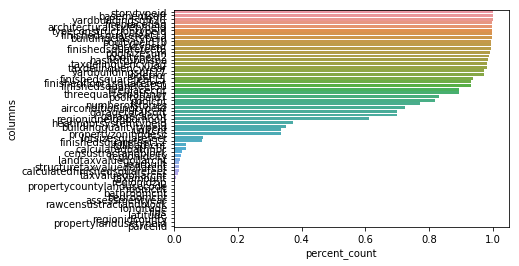

In [173]:
sns.barplot(x='percent_count', y ='columns', data=df)

Features with unique values 

In [174]:
unique_features = []
for c in data.columns:
    unique_count = len(data[c].unique())
    if data[c].isnull().sum() !=0:
        unique_count -= 1
    if unique_count == 1:
        unique_features.append(c)

In [175]:
unique_features

['decktypeid',
 'fireplaceflag',
 'hashottuborspa',
 'poolcnt',
 'pooltypeid10',
 'pooltypeid2',
 'pooltypeid7',
 'storytypeid',
 'taxdelinquencyflag']

In [176]:
data = data.drop(unique_features, axis=1)

In [177]:
for c in df['columns'].values:
    if c in unique_features:
        df = df[df['columns'] != c]

In [97]:
y_train= train_data['logerror']

In [178]:
threshold_null = 0.95
drop_features = []
for percent in df['percent_count']:
    if percent >= threshold_null:
        drop_features.append(list(df[df.percent_count == percent]['columns'].values))

In [180]:
drop_features = list(np.squeeze(np.array(drop_features)))

In [181]:
drop_features = drop_features[0:len(drop_features)-1]

In [183]:
data = data.drop(drop_features,axis=1)

In [187]:
for c in df['columns'].values:
    if c in drop_features:
        df = df[df['columns'] != c]

In [188]:
x_train_test = data[list(df['columns'].values)]

In [190]:
df = df.sort_values('unique count')
df.reset_index(drop='True',inplace=True)

replace categorical elements with mode

In [213]:
categorical_features = []
categorical_non_features = []
for row in range(len(df)):
    if df.loc[row]['unique count'] <= 20:
        categorical_features.append(df.loc[row]['columns'])
    elif df.loc[row]['columns'] != 'logerror' and df.loc[row]['columns'] != 'parcelid':
        categorical_non_features.append(df.loc[row]['columns'])

In [215]:
for c in x_train_test.columns:
    if c in categorical_features:
        x_train_test[c].fillna(float(x_train_test[c].mode()), inplace=True)

In [220]:
for c in x_train_test.columns:
    if c in categorical_non_features:
        if x_train_test[c].dtype == np.float64 or x_train_test[c].dtype == np.int64:
            x_train_test[c].fillna(float(x_train_test[c].mean()), inplace=True)

In [221]:
remaining_features = []
for feat in x_train_test.columns:
    if (x_train_test[feat].isnull().sum() != 0):
        remaining_features.append(feat)

In [223]:
cat_features = remaining_features[1:] + categorical_features

In [226]:
le = LabelEncoder()
for i,c in enumerate(cat_features):
    if (x_train_test[c].isnull().sum() != 0):
        x_train_test[c].fillna(str(x_train_test[c].mode()), inplace=True)
    x_train_test[c]= le.fit_transform(x_train_test[c])

In [262]:
x_test = x_train_test[x_train_test['logerror'].isnull()]
x_train = x_train_test[x_train_test['logerror'].notnull()]

In [263]:
y_train = x_train['logerror']

In [242]:
x_train = x_train.drop(['logerror', 'parcelid'], axis = 1)

In [244]:
x_test = x_test.drop(['logerror', 'parcelid'], axis=1)

In [266]:
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)

In [268]:
num_ensembles = 5
y_pred = 0.0
for i in range(num_ensembles):
    print str(i) + ' / ' + str(num_ensembles) + ' done '
    model = CatBoostRegressor(iterations=200, learning_rate=0.03, depth=6, l2_leaf_reg=3, loss_function='MAE', eval_metric='MAE', random_seed=i) 
    model.fit(x_train, y_train)
    y_pred += model.predict(x_test)
y_pred /= num_ensembles

0 / 5 done 
1 / 5 done 
2 / 5 done 
3 / 5 done 
4 / 5 done 


In [272]:
test_data

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,10754147,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,9.0,2016.0,9.0,NaN,NaN,NaN,NaN
1,10759547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,27516.0,2015.0,27516.0,NaN,NaN,NaN,NaN
2,10843547,NaN,NaN,NaN,0.0,0.0,5.0,NaN,NaN,NaN,...,1.0,NaN,660680.0,1434941.0,2016.0,774261.0,20800.37,NaN,NaN,NaN
3,10859147,NaN,NaN,NaN,0.0,0.0,3.0,6.0,NaN,NaN,...,1.0,NaN,580059.0,1174475.0,2016.0,594416.0,14557.57,NaN,NaN,NaN
4,10879947,NaN,NaN,NaN,0.0,0.0,4.0,NaN,NaN,NaN,...,1.0,NaN,196751.0,440101.0,2016.0,243350.0,5725.17,NaN,NaN,NaN
5,10898347,NaN,NaN,NaN,0.0,0.0,4.0,4.0,NaN,NaN,...,1.0,NaN,179072.0,287634.0,2016.0,108562.0,3661.28,NaN,NaN,NaN
6,10933547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,404013.0,563029.0,2016.0,159016.0,6773.34,NaN,NaN,NaN
7,10940747,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,1.0,NaN,103553.0,698984.0,2016.0,595431.0,7857.84,NaN,NaN,NaN
8,10954547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,9.0,2016.0,9.0,NaN,NaN,NaN,NaN
9,10976347,NaN,NaN,NaN,0.0,0.0,3.0,4.0,NaN,NaN,...,1.0,NaN,221771.0,265184.0,2016.0,43413.0,4054.76,NaN,NaN,NaN


In [277]:
submission = pd.DataFrame({'ParcelId': test['ParcelId']})
test_dates = {
    '201610': pd.Timestamp('2016-09-30'),
    '201611': pd.Timestamp('2016-10-31'),
    '201612': pd.Timestamp('2016-11-30'),
    '201710': pd.Timestamp('2017-09-30'),
    '201711': pd.Timestamp('2017-10-31'),
    '201712': pd.Timestamp('2017-11-30')
}

In [279]:
for label, test_date in test_dates.items():
    print("Predicting for: %s ... " % (label))
    y_pred = model.predict(x_test)
    submission[label] = y_pred

submission_major = 1
submission.to_csv(
    'submission_%03d.csv' % (submission_major),
    float_format='%.4f',
    index=False)
print("Done! Good luck with submission #%d :)" % submission_major)

Predicting for: 201612 ... 
Predicting for: 201610 ... 
Predicting for: 201611 ... 
Predicting for: 201712 ... 
Predicting for: 201711 ... 
Predicting for: 201710 ... 
Done! Good luck with submission #1 :)
